In [1]:
import numpy as np
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, descriptors_from_traj, sample
from stateinterpreter.plot import plot_states
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
stride = 100
#Load Collective Variables
colvar = load_dataframe(colvar_file, stride=stride).drop(['time'], axis=1)
#Compute descriptors
descriptors, feats_info = descriptors_from_traj(traj_dict, descriptors=['dihedrals'], stride= stride)

Descriptors: (5248, 102)


DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 955 configurations.
	Basin 1 -> 719 configurations.
	Basin 2 -> 673 configurations.
	Basin 3 -> 2364 configurations.


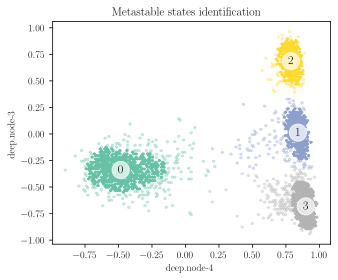

In [5]:
cv_list = ['deep.node-4', 'deep.node-3']
kBT = 2.8
states_labels = identify_metastable_states(colvar, cv_list, kBT, bw_method=0.07)
plot_states(colvar, states_labels, cv_list, fes_isolines=False);

In [6]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'sin_|cos_'
states_names = [
    'Unfolded',
    'Folded Mid',
    'Folded High',
    'Folded Low'
]
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, regex_filter = select_feat, states_names=states_names)
groups = [feats_info[name]['group'] for name in features_names]
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, groups=groups)

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]


Accuracy: 97%
State Unfolded:
[41.939%]  THR6
[41.152%]  ASP3
[14.825%]  THR8
[2.047% ]  TYR2
[0.037% ]  GLY7
State Folded Mid:
[46.401%]  THR6
[28.8%  ]  ASP3
[23.083%]  THR8
[1.687% ]  TYR2
[0.029% ]  GLY7
State Folded High:
[53.425%]  THR6
[45.301%]  THR8
[1.162% ]  ASP3
[0.069% ]  TYR2
[0.044% ]  GLY7
State Folded Low:
[57.898%]  THR6
[38.21% ]  THR8
[3.647% ]  ASP3
[0.207% ]  TYR2
[0.038% ]  GLY7


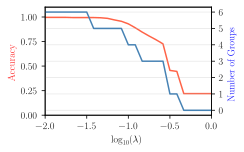

In [7]:
reg = 10**(-1.2)
classifier.print_selected(reg)
classifier.plot();

A note on the problem to solve:
1. For regular Lasso $$ \min_{w}C\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \Vert w \Vert_{1}$$
2. For _group_ Lasso $$ \min_{w} \frac{1}{n}\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \lambda \sum_{j}  \Vert w_{j} \Vert_{2}$$

To have everything consistent $C \mapsto (\lambda n)^{-1}$. I'll use $\lambda$ as regularization parameter.